In [34]:
import numpy as np
from matplotlib.pyplot import imshow, figure, subplot,setp
from matplotlib.pyplot import plot, gcf
from matplotlib.pyplot import show


In [35]:
#for 5x5 kernels
def convolution(img, kernel):
    
    pixel = lambda local, kernel: (local * kernel).sum()
    get_local = lambda image, i, j: image[i:i+5, j:j+5]
    
    result = np.zeros_like(img)[4:, 4:]
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            p = pixel(get_local(img, i, j), kernel)
            if p > 128:
                result[i,j] = p
    return result

In [36]:
#fetch function is awailable in another notebook
X_train = np.load("/home/const/convnet/X_train.npy")
Y_train = np.load("/home/const/convnet/Y_train.npy")
X_test = np.load("/home/const/convnet/X_test.npy")
Y_test = np.load("/home/const/convnet/Y_test.npy")

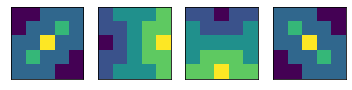

In [205]:
#these kernals probably suck
kernels = np.array(
    [
    np.array([[-1,-1, 0, 0, 0],
              [-1, 0, 0, 1, 0],
              [0, 0, 2, 0, 0],
              [0, 1, 0, 0, -1],
              [0, 0, 0, -1,-1]]),       
    
 #$   np.array([[0, 0, 0, 0, 0],
 #$             [0, 0, 0, 1, 0],
   #$           [0, 0, 1, 0, 0],
     #$         [0, 1, 0, 0, 0],
       #$       [0, 0, 0, 0, 0]]) / 3,
    
    np.array([[-1, 0, 0, 0, 1],
              [-1, -1, 0, 1, 1],
              [-2,-1,0, 1, 2],
              [-1, -1, 0, 1, 1],
              [-1, 0, 0, 0, 1]]),    
    
  #$  np.array([[0, 0, 1, 0, 0],
    #$          [0, 0, 1, 0, 0],
      #$        [0, 1, 1, 1, 0],
        #$      [0, 0, 1, 0, 0],
          #$    [0, 0, 1, 0, 0]]) / 7,
   
  #$  np.array([[0, 0, 0, 0, 0],
    #$          [0, 0, 1, 0, 0],
      #$        [1, 1, 1, 1, 1],
        #$      [0, 0, 1, 0, 0],
          #$    [0, 0, 0, 0, 0]]) / 7,      
 
    np.array([[-1, -1, -2, -1, -1],
              [0, -1, -1, -1, 0],
              [0, 0, 0, 0, 0],
              [0, 1, 1, 1, 0],
              [1, 1, 2, 1,1]]),    
    
  #$  np.array([[0, 0, 0, 0, 0],
    #$          [0, 1, 0, 0, 0],
      #$        [0, 0, 1, 0, 0],
        #$      [0, 0, 0, 1, 0],
          #$    [0, 0, 0, 0, 0]]) / 3  
    
    np.array([[0, 0, 0, -1, -1],
              [0, 1, 0, 0, -1],
              [0, 0, 2, 0, 0],
             [-1, 0, 0, 1, 0],
              [-1, -1, 0, 0, 0]])
    ]
)

figure()
for i in range(4):
    subplot(1,4,i+1)
    imshow(kernels[i])
    
setp(gcf().get_axes(), xticks=[], yticks=[]);

In [206]:
def convlayer(img):
    return  np.array([convolution(img, ker)
                      for ker in kernels])

def maxpool(img):
    h = int(img.shape[0]/2)
    w = int(img.shape[1]/2)
    result = np.zeros((h, w))
    chunk = lambda image, i, j: image[i:i+2, j:j+2]
    for i in range(h):
        for j in range(w):
            result[i,j] = np.max(chunk(img, 2*i, 2*j))
    return result    

def feedwfd(img):
    flat = lambda layer: np.concatenate(
        [im.reshape(1, -1)[0] for im in layer]
         ).reshape(-1,1)
    mplayer = lambda layer: np.array([maxpool(im) for im in layer])
    
    return flat(mplayer(convlayer(img)))

In [207]:
def m(m, n):
    matrix = np.random.uniform(-1, 1, size=(m,n))
    return matrix / np.sqrt(m*n)

relu = lambda x: np.maximum(x, 0.)

def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def matrix_softmax(m):
    return np.apply_along_axis(softmax, 0, m)

def row(n):
    return [1 if i == n else 0 for i in range(10)]

#picks a batch of train inputs of size bs and number i;
#used in training loop;
def get_batch(x, bs, i):
    return x[bs*i : bs*(i+1)].T 

#picks a batch of train outputs;
def get_y(y, bs, i):
    return y[bs*i : bs*(i+1)].T

y = np.array([row(n) for n in Y_train])


In [208]:
def grads(train, labels,  W1, b1):

    l1 = train
    x2 = W1 @ l1 + b1
    l2 = matrix_softmax(x2[0])

    dloss_dx2 = (l2 - labels).T
    dx2_dl1 = W1
    dx2_dW1 = (l1[0].T)
 
    dloss_dW1 = dloss_dx2.T @ dx2_dW1
    dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)
    
    return ( dloss_dW1,  dloss_db1)

In [209]:
#layer after convolution and max pooling
s = np.array([feedwfd(img) for img in X_train[:5000]])

In [199]:
5000/100

50.0

In [210]:
W1 = m(10, 576)
b1 = m(10, 1)

#training loop with batch size 256 and learning rate 0.0045
#230 epoches
lr = 0.0045
for i in range(100):
    x_train = get_batch(s, 50, i)
    y_train = get_y(y, 50, i)
    
    #how sensitive is loss to small changes in parameters?
    dloss_dW1,  dloss_db1 = grads(x_train, y_train, W1,  b1)
    
    #minimising loss by nudging parameters;
    W1 = W1 - dloss_dW1 * lr
    b1 = b1 - dloss_db1 * lr
    #getting better parameters as a result;

In [71]:
x_test.shape

(1000, 288, 1)

In [65]:
def get_examnple(i):
    return get_batch(x_test, 1, i)

In [212]:
def predict(img):
    l1 = feedwfd(img)
    x2 = W1 @ l1 + b1
    l2 = softmax(x2)
    return np.argmax(l2)

def predict2(img):
    l1 = img
    x2 = W1 @ l1 + b1
    l2 = softmax(x2)
    return np.argmax(l2)

yt = np.array([row(n) for n in Y_test])
x_test = np.array([feedwfd(img) for img in X_test[:1000]])
mistakes = sum([(predict2(get_examnple(i)) - np.argmax(yt[i]) != 0) + 0. for i in range(1000)])
(1000 - mistakes) / 1000

0.831

In [131]:
predict2(x_test[0])

7

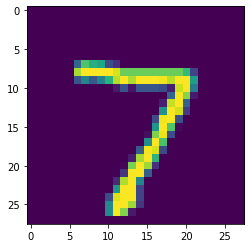

In [69]:
imshow(X_test[0])

6


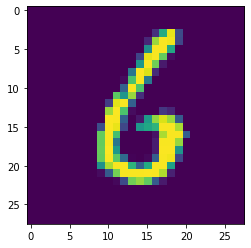

3


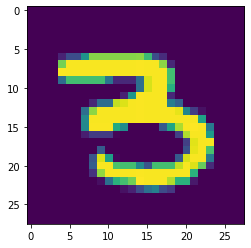

5


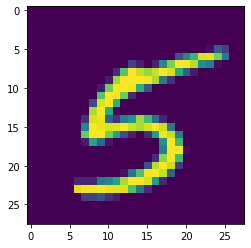

5


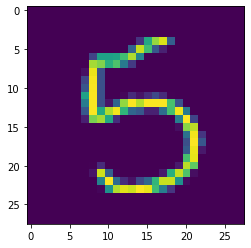

6


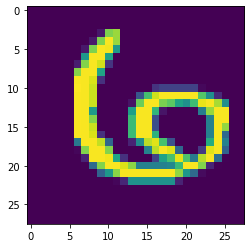

0


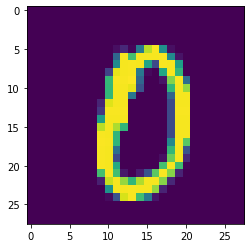

4


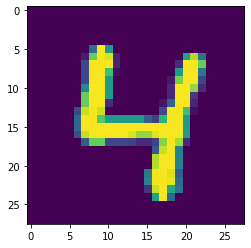

1


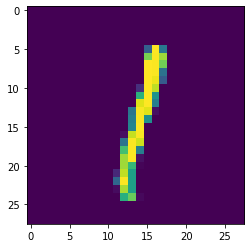

9


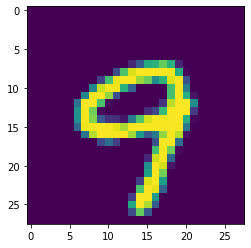

8


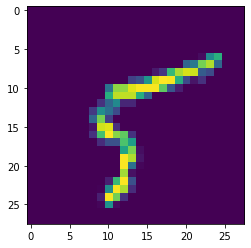

7


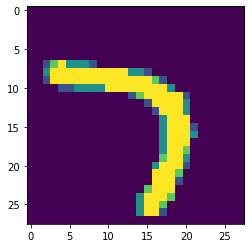

8


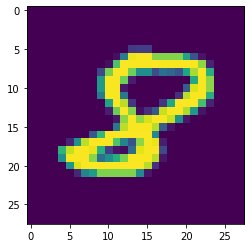

9


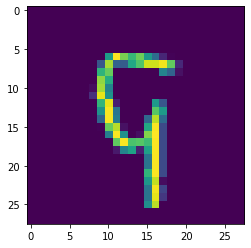

2


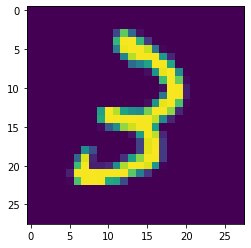

7


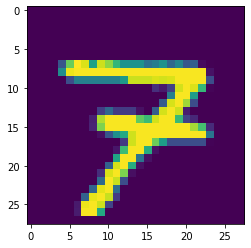

9


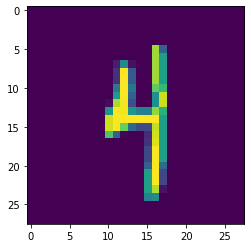

6


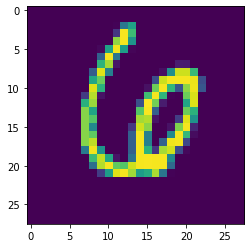

4


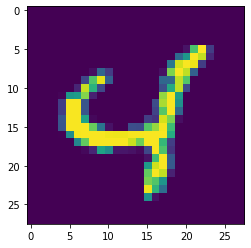

3


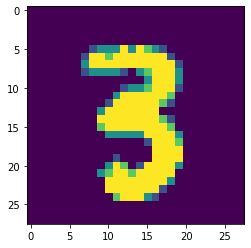

0


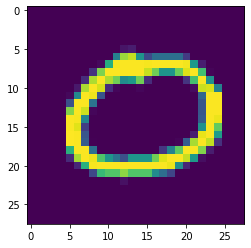

7


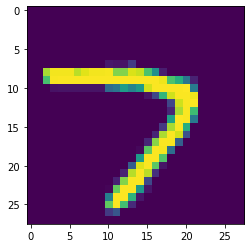

0


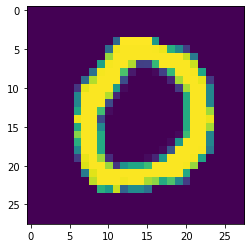

2


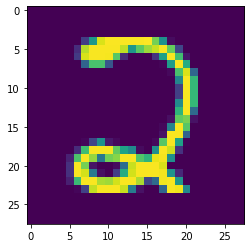

9


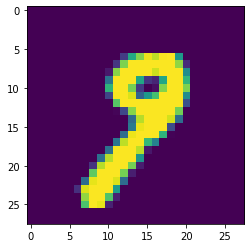

1


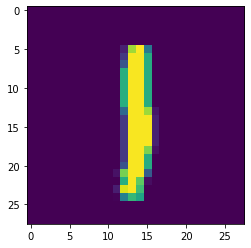

7


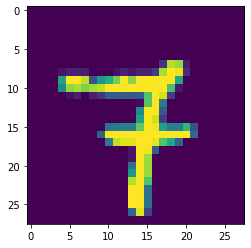

3


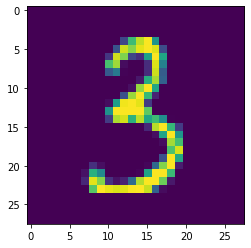

7


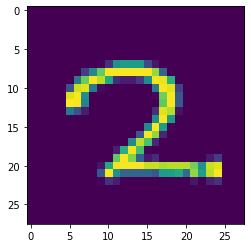

8


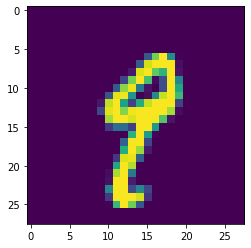

7


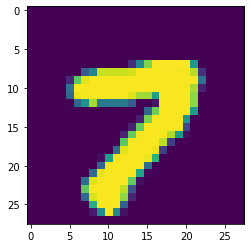

9


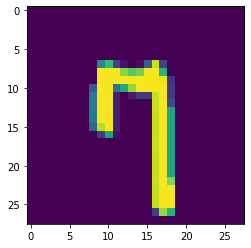

6


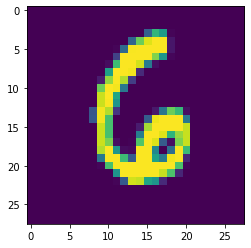

2


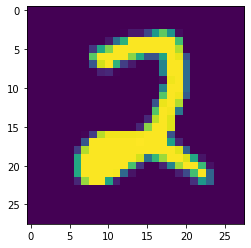

7


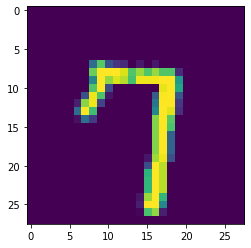

8


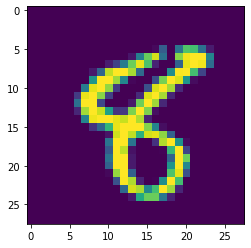

4


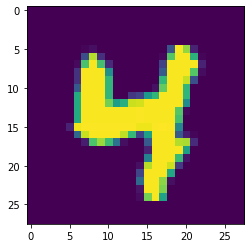

7


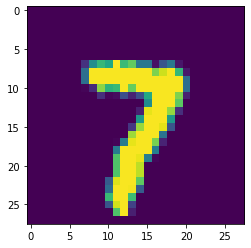

3


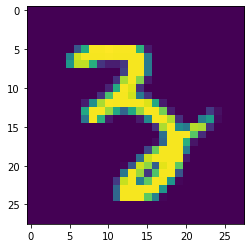

6


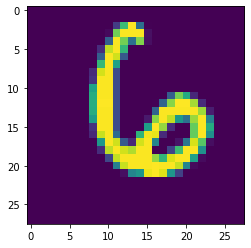

1


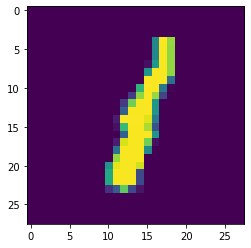

3


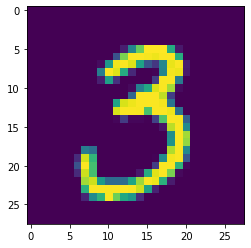

6


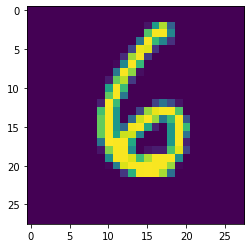

9


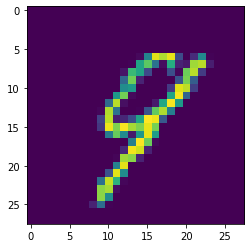

3


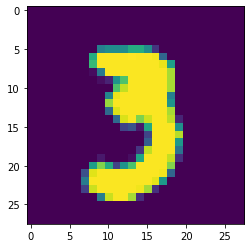

1


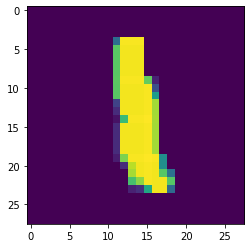

4


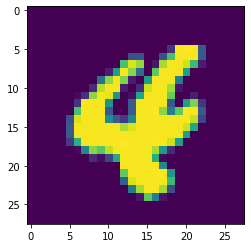

3


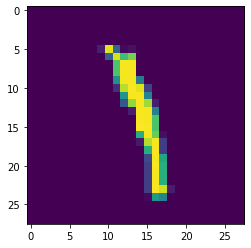

4


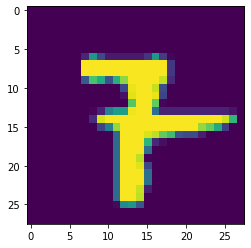

6


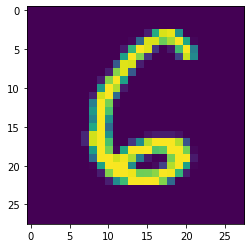

9


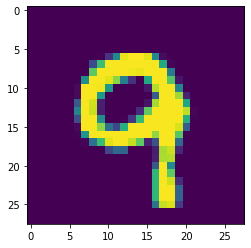

6


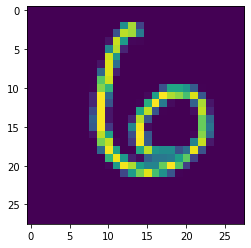

0


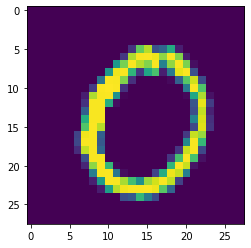

5


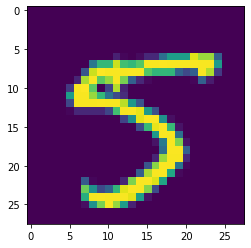

4


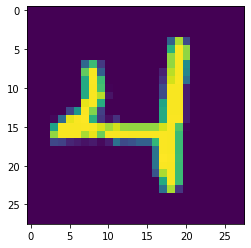

9


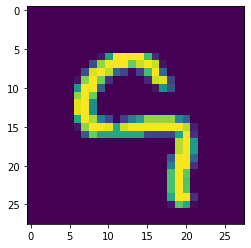

9


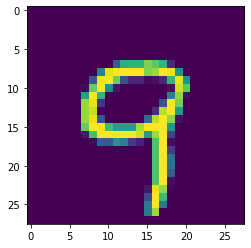

2


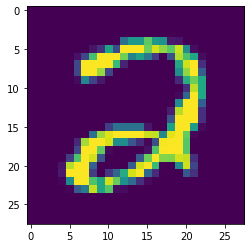

1


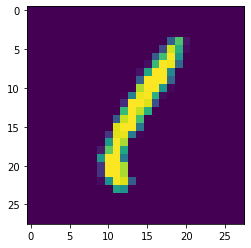

9


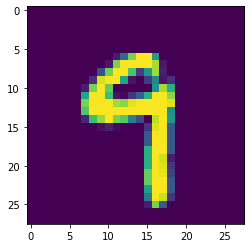

4


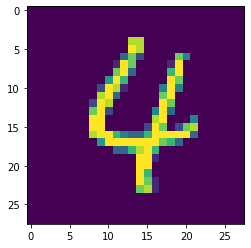

8


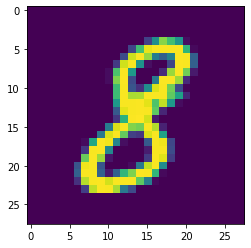

1


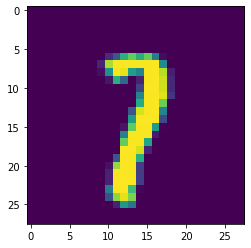

3


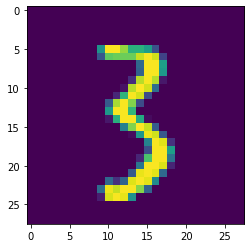

9


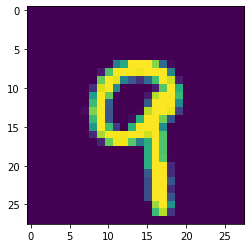

7


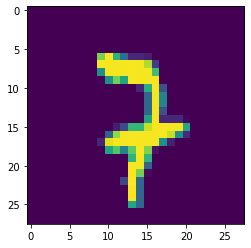

4


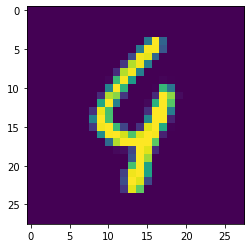

4


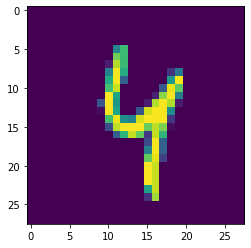

4


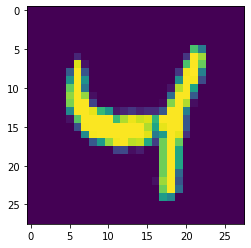

9


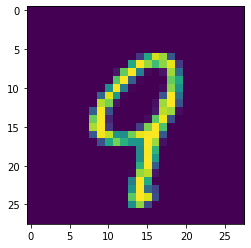

9


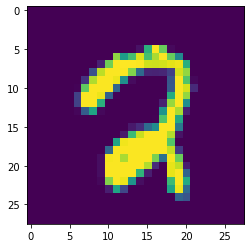

5


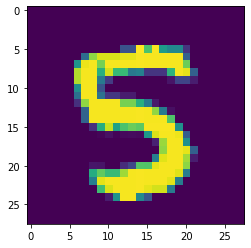

8


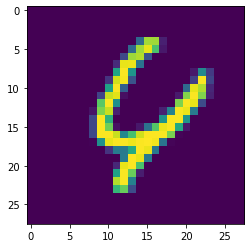

7


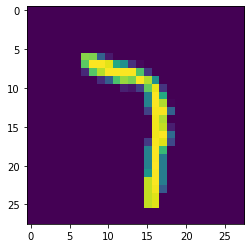

6


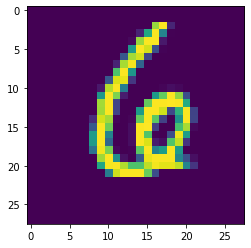

7


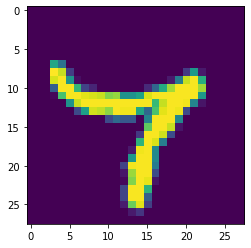

9


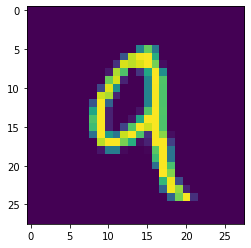

3


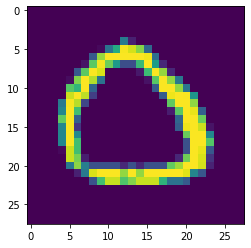

5


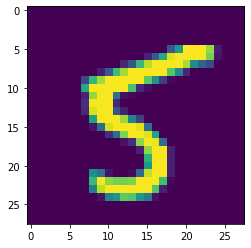

8


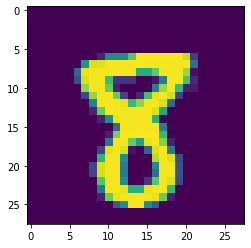

5


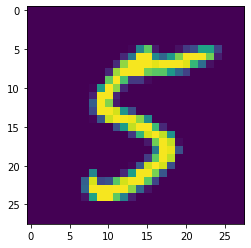

6


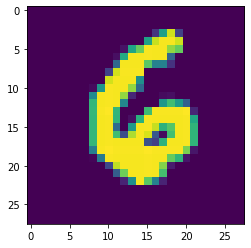

6


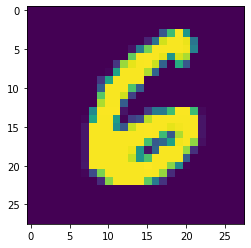

5


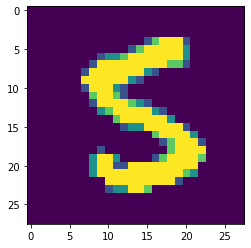

7


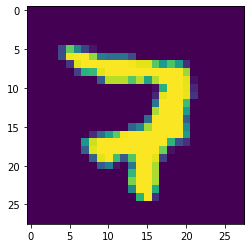

8


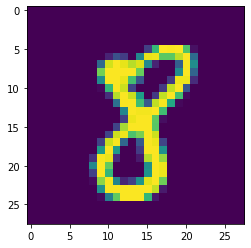

1


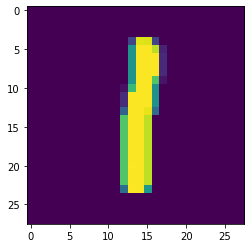

0


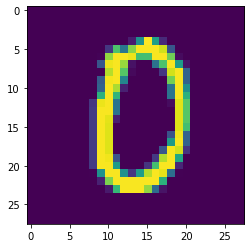

1


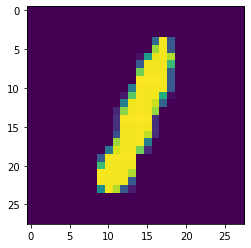

6


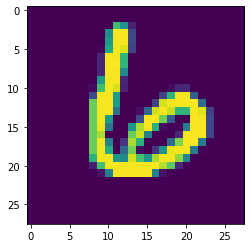

4


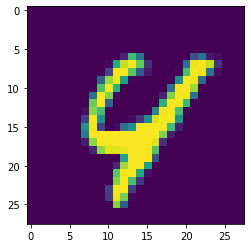

6


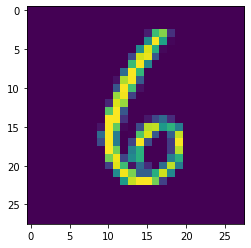

7


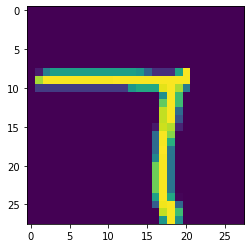

3


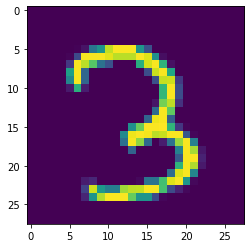

1


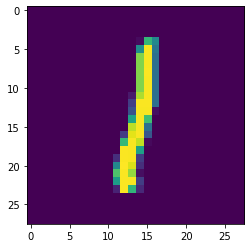

7


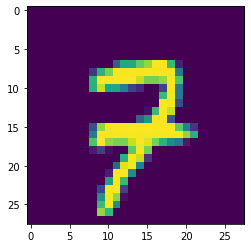

1


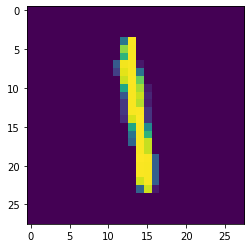

8


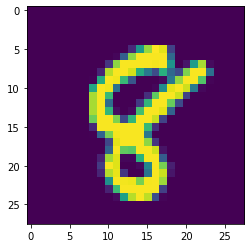

2


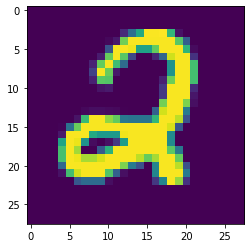

0


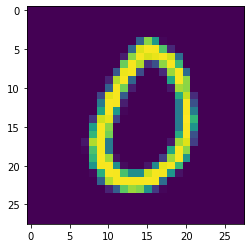

2


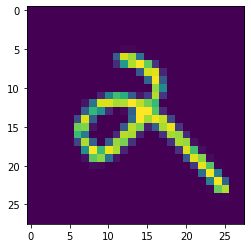

In [189]:
for i in range(50,150):
    print(predict(X_test[i]))
    imshow(X_test[i])
    show()
          

In [176]:
w = convolution(X_test[0], kernels[0])

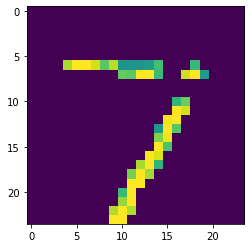

In [177]:
imshow(w)

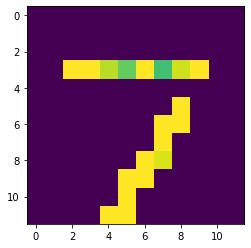

In [178]:
e = maxpool(w)
imshow(e)

In [160]:
12*12*4

576

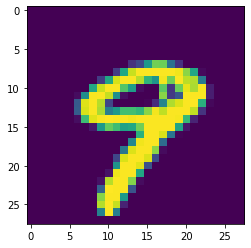

In [138]:
imshow(X_test[9])

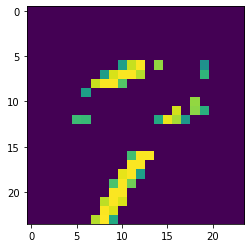

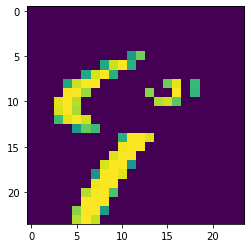

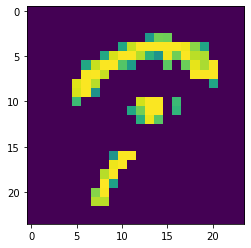

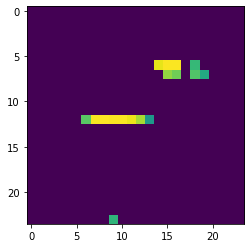

In [175]:
for im in convlayer(X_test[9]):
    imshow(im)
    show()

In [180]:
np.save("/home/const/convnet/b1",b1)